In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(rc={"figure.figsize": (12, 8)}) # Set default figure size
sns.set_style("darkgrid")

pd.options.display.float_format = "{:.4f}".format # Pandas significant digits

In [2]:
from IPython.display import display_html

"""
Display pandas dataframes side by side
"""
def display_side_by_side(*args):

    html_str=''

    for df in args:
        html_str+=df.to_html()

    display_html(html_str.replace('table','table style="display:inline"'),raw=True)

In [3]:
df = pd.read_csv("five/ROL.csv", delimiter=";")

In [4]:
df["Applied to first"] = (df["Application"] == df["ROL 1"]).apply(int)

In [5]:
roundcols = [col for col in df.columns if "round" or "Points" in col]

In [6]:
for col in roundcols:
    df[col] = df[col].apply(lambda point: float(str(point).replace(",", ".")))

In [7]:
N, K = df.shape

### Excercise 1

Which fraction of the students does not apply to the most preferred school?
Does this differ by test score, gender and household income?

In [8]:
rel_columns = ["Test score", "Female", "Low Income"]

In [9]:
didapply = df[df["Applied to first"] == 1][rel_columns]
didnotapply = df[df["Applied to first"] == 0][rel_columns]

statistics = ["count", "mean", "std"]

display_side_by_side(
    didapply.describe().loc[statistics], 
    didnotapply.describe().loc[statistics]
)

,Test score,Female,Low Income
count,1054.0000,1054.0000,1054.0000
mean,546.8444,0.4867,0.2723
std,3.0774,0.5001,0.4454
,Test score,Female,Low Income
count,70.0000,70.0000,70.0000
mean,544.1714,0.4857,0.2857
std,4.1667,0.5034,0.4550


In [10]:
isfemale = df["Female"] == 1
islowincome = df["Low Income"] == 1

In [95]:
def kdeplot(df, title, ax, x = "Test score", legend=False):
    g = sns.kdeplot(
        data=df, x=x, hue="Applied to first", 
        palette="crest", alpha=.5, linewidth=0., fill=True,
        common_norm=False, ax=ax)

    if not legend: ax.legend([], [], frameon=False)

    ax.set_title(title)


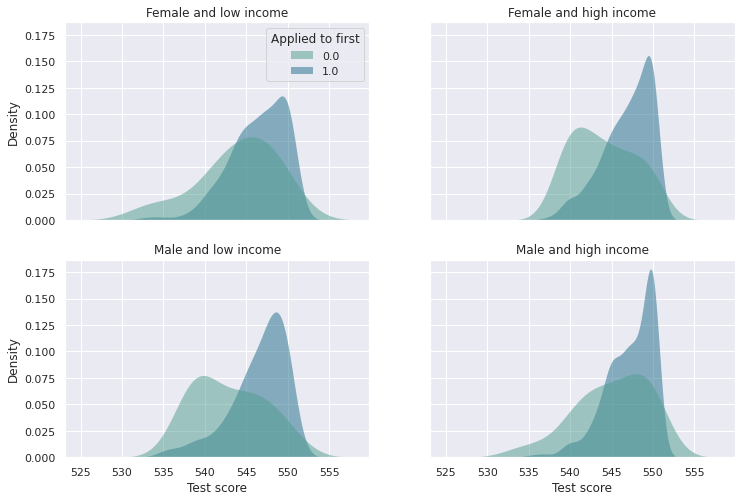

In [12]:
fig, axes = plt.subplots(2, 2, sharex=True, sharey=True)

kdeplot(df[isfemale & islowincome], "Female and low income", axes[0, 0], legend=True)
kdeplot(df[isfemale & ~islowincome], "Female and high income", axes[0, 1])
kdeplot(df[~isfemale & islowincome], "Male and low income", axes[1, 0])
kdeplot(df[~isfemale & ~islowincome], "Male and high income", axes[1, 1])

fig.show()

### Exercise 2

Relate the decision not to apply to the most preferred school to the ad-
mission probability and to the difference in utility (points) between the
most-preferred school and the second most-preferred school.

In [13]:
from statsmodels.discrete.discrete_model import Logit, LogitResults

In [14]:
X = np.zeros((N, 2))

X[:, 0] = df["P1 round 1"]
X[:, 1] = df["Points 1"] - df["Points 2"]
X = pd.DataFrame(X, columns=["Acceptance prob.", "Point differential"])

y = df["Applied to first"]



In [15]:
model = Logit(y, X)
res = model.fit()

print(res.summary())



Optimization terminated successfully.
         Current function value: 0.208235
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:       Applied to first   No. Observations:                 1124
Model:                          Logit   Df Residuals:                     1122
Method:                           MLE   Df Model:                            1
Date:                Wed, 10 Feb 2021   Pseudo R-squ.:                  0.1070
Time:                        17:04:08   Log-Likelihood:                -234.06
converged:                       True   LL-Null:                       -262.10
Covariance Type:            nonrobust   LLR p-value:                 6.902e-14
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Acceptance prob.       2.8421      0.194     14.674      0.000       2.463       3.222
Point

### Exercise 3

Compute the expect utility (points) when applying to the most preferred
school. Assume that for the second and third round students make the
optimal choice. What is the average expected utility over all students?

In [16]:
col_points = [col for col in df.columns if "Points" in col]

col_prob = { round: [col for col in df.columns if f"round {round}" in col] for round in [1, 2, 3] }

First we find the expected utilitites of all rounds, namely,

\begin{equation}
    U_{i, j} \cdot P^k_{i, j}, \ k \in \{1, 2, 3\}, \ i \in N, \ j \in \{1, \ldots, 10 \}
\end{equation}

In [17]:
# Three matrices with probabilities per round
prob_round1, prob_round2, prob_round3 = [ df[col_prob[i]].to_numpy() for i in [1, 2, 3] ]

# Three expected utilites per round for all choices
eu_round1 = df[col_points].to_numpy() * prob_round1
eu_round2 = df[col_points].to_numpy() * prob_round2
eu_round3 = df[col_points].to_numpy() * prob_round3


Then we assume that students apply to the first school first, and hence the expected utility is,

\begin{equation}
    \underbrace{U_{i, 1} \cdot P^1_{i, 1}}_{\text{first round}} + (1 - P^1_{i, 1}) \cdot \left( \underbrace{U_{i, j} \cdot P^2_{i,j}}_{\text{second round with opt } j} + (1 - P^2_{i, j}) \cdot \underbrace{U_{i, l} \cdot P^3_{i,l}}_{\text{third round with opt. } l}  \right)
\end{equation} 

Here we assume that a student can apply multiple rounds in the same school

In [18]:
students_idxs = np.arange(N)

In [19]:
first_round = eu_round1[:, 0] # Expected utility of first round
P_first_round =prob_round1[:, 0]

In [20]:
opt_choice2 = np.argmax(eu_round2, axis = 1) # Get the argmax of the second round optimization

P_second_round = prob_round2[students_idxs, opt_choice2] # Get the probability of the second round optimum choice
second_round = eu_round2[students_idxs, opt_choice2] # Get the expected utility of the second round optimum choice

In [21]:
third_round = np.max(eu_round3, axis = 1) 

In [22]:
expected_utility = \
    first_round + \
        (1 - P_first_round) * (second_round + \
            (1 - P_second_round) * third_round)

df["First Choice Expected Utility"] = expected_utility


In [23]:
def histplot(df, xkey, title, ax, legend=False):

    g = sns.histplot(
        data=df, x=xkey, hue="Applied to first", stat="probability",
        fill=True, multiple="stack",
        common_norm=False, ax=ax)

    if not legend: ax.legend([], [], frameon=False)

    ax.set_title(title)

In [24]:
fig, axes = plt.subplots(2, 2, sharey=True)
xkey = "First Choice Expected Utility"

histplot(df[isfemale & islowincome], xkey, "Female and low income", axes[0, 0], legend=True)
histplot(df[isfemale & ~islowincome], xkey, "Female and high income", axes[0, 1])
histplot(df[~isfemale & islowincome], xkey, "Male and low income", axes[1, 0])
histplot(df[~isfemale & ~islowincome], xkey, "Male and high income", axes[1, 1])

fig.savefig(f"five/plots/{xkey.lower().replace(' ', '_')}.png")

plt.close()

### Exercise 4

What is the optimal first round application?
And what is the average
expected utility over all students when all students apply optimal (assume
that changing the first round application does not affect the admission
probabilities).

We use the same procedure as above but the first round application is also maximized by the students

In [25]:
opt_choice1 = np.argmax(eu_round1, axis = 1) # Get the argmax of the second round optimization

P_first_round_opt = prob_round1[students_idxs, opt_choice1] # Get the probability of the first round optimum choice
first_round_opt = eu_round1[students_idxs, opt_choice1] # Get the expected utility of the first round optimum choice

In [26]:
choices = ["First", "Second", "Third", "Fourth"]

df["Optimal Choice"] = [choices[c] for c in opt_choice1]

In [38]:
sns.catplot(
    x = "Optimal Choice", y="Test score", hue="Female", 
    kind = "boxen", data = df, height=8, aspect=11.7/8)

plt.savefig("five/plots/optimal_choice.png")
plt.close()


<img src="plots/optimal_choice.png" alt="Drawing"/>

In [28]:
opt_expected_utility = \
    first_round_opt + \
        (1 - P_first_round_opt) * (second_round + \
            (1 - P_second_round) * third_round)

df["Optimal Expected Utility"] = opt_expected_utility

In [29]:
fig, axes = plt.subplots(2, 2,sharey=True)
xkey = "Optimal Expected Utility"

histplot(df[isfemale & islowincome], xkey, "Female and low income", axes[0, 0], legend=True)
histplot(df[isfemale & ~islowincome], xkey, "Female and high income", axes[0, 1])
histplot(df[~isfemale & islowincome], xkey, "Male and low income", axes[1, 0])
histplot(df[~isfemale & ~islowincome], xkey, "Male and high income", axes[1, 1])

fig.savefig(f"five/plots/{xkey.lower().replace(' ', '_')}.png")

plt.close()

<img src="plots/first_choice_expected_utility.png" alt="Drawing" style="width: 500px;"/>
<img src="plots/optimal_expected_utility.png" alt="Drawing" style="width: 500px;"/>

In [30]:
col_utilities = ["Optimal Expected Utility", "First Choice Expected Utility"]
df[col_utilities].describe()

,Optimal Expected Utility,First Choice Expected Utility
count,1124.0000,1124.0000
mean,96.5609,96.2907
std,8.3402,11.1327
min,0.0000,0.0000
25%,95.9935,97.1988
50%,99.7591,99.7030
75%,99.9999,99.9999
max,100.0000,100.0000


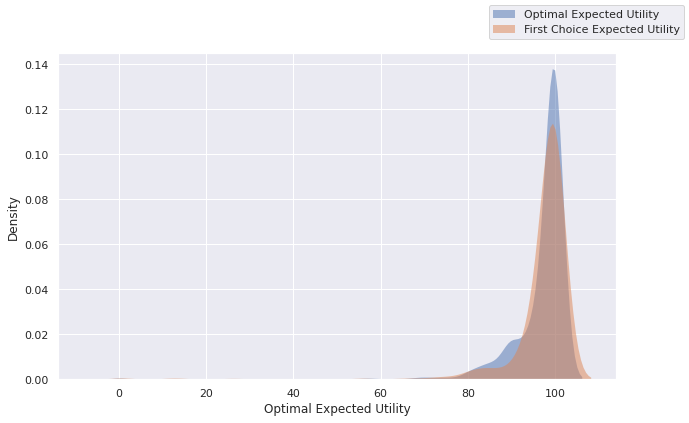

In [31]:
fig, ax = plt.subplots(figsize = (10, 6))

sns.kdeplot(
        data=df, x=col_utilities[0], 
        alpha=.5, linewidth=0., fill=True, 
        label = col_utilities[0], ax=ax)

sns.kdeplot(
        data=df, x=col_utilities[1], 
        alpha=.5, linewidth=0., fill=True, 
        label=col_utilities[1], ax=ax)

fig.legend()
fig.show()

### Question 5

Students can make two types of strategic mistakes: 
 - (a) wrongfully applying to the most-preferred school
 - (b) wrongfully not applying to the most-preferred school. What is the incidence rate of both mistakes and what are the expected utility costs of both mistakes?

In [75]:
df["Error a"] = (df["Applied to first"] == 1) & (df["Optimal Choice"] != "First")
df["Error b"] = (df["Applied to first"] == 0) & (df["Optimal Choice"] == "First")

In [76]:
print(f"{df['Error a'].value_counts()[True]} students commited error (a) and {df['Error b'].value_counts()[True]} error (b)")

157 students commited error (a) and 39 error (b)


Use a logit model to find Error a and error b probabilities

In [82]:
df.head()

,Application,Test score,Female,Low Income,ROL 1,Points 1,P1 round 1,P1 round 2,P1 round 3,ROL 2,...,Points 10,P10 round 1,P10 round 2,P10 round 3,Applied to first,First Choice Expected Utility,Optimal Choice,Optimal Expected Utility,Error a,Error b
0,25.0000,546.0000,0.0000,0.0000,25.0000,100.0000,0.9888,0.7329,0.0000,4.0000,...,0.0000,0.0000,0.0000,0.0000,1.0000,99.6999,First,99.6999,False,False
1,9.0000,539.0000,1.0000,0.0000,9.0000,100.0000,0.8111,0.0040,0.0000,28.0000,...,0.0000,0.0000,0.0000,0.0000,1.0000,94.3324,First,94.3324,False,False
2,8.0000,550.0000,0.0000,0.0000,8.0000,100.0000,1.0000,0.8384,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,1.0000,99.9998,First,99.9998,False,False
3,27.0000,548.0000,1.0000,0.0000,27.0000,100.0000,0.9883,0.3173,0.0000,4.0000,...,0.0000,0.0000,0.0000,0.0000,1.0000,99.5687,First,99.5687,False,False
4,9.0000,543.0000,1.0000,0.0000,9.0000,100.0000,0.8111,0.0040,0.0000,3.0000,...,0.0000,0.0000,0.0000,0.0000,1.0000,82.9951,First,82.9951,False,False


In [133]:
char = [
    "Test score", "Female", "Low Income", "P1 round 1", "P1 round 2", "P1 round 3"
]

In [134]:
X = df[char]

y_a = df["Error a"].apply(int)
y_b = df["Error b"].apply(int)

In [135]:
res_a = Logit(y_a, X).fit()
res_b = Logit(y_b, X).fit()

print(res_a.summary(), "\n\n", res_b.summary())

Optimization terminated successfully.
         Current function value: 0.284417
         Iterations 22
Optimization terminated successfully.
         Current function value: 0.147689
         Iterations 9
                           Logit Regression Results                           
Dep. Variable:                Error a   No. Observations:                 1124
Model:                          Logit   Df Residuals:                     1118
Method:                           MLE   Df Model:                            5
Date:                Wed, 10 Feb 2021   Pseudo R-squ.:                  0.2967
Time:                        17:32:24   Log-Likelihood:                -319.68
converged:                       True   LL-Null:                       -454.52
Covariance Type:            nonrobust   LLR p-value:                 3.278e-56
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Test 

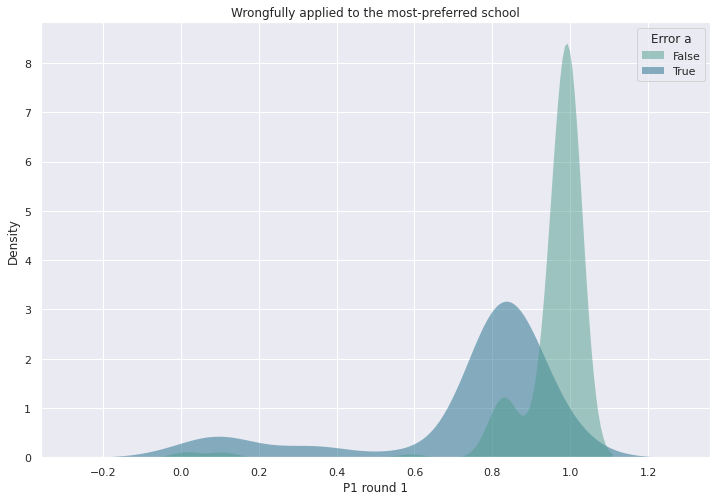

In [136]:
fig, ax = plt.subplots()

sns.kdeplot(
    data=df, x="P1 round 1", hue="Error a", 
    palette="crest", alpha=.5, linewidth=0., fill=True,
    common_norm=False, ax=ax)

ax.set_title("Wrongfully applied to the most-preferred school")

fig.show()

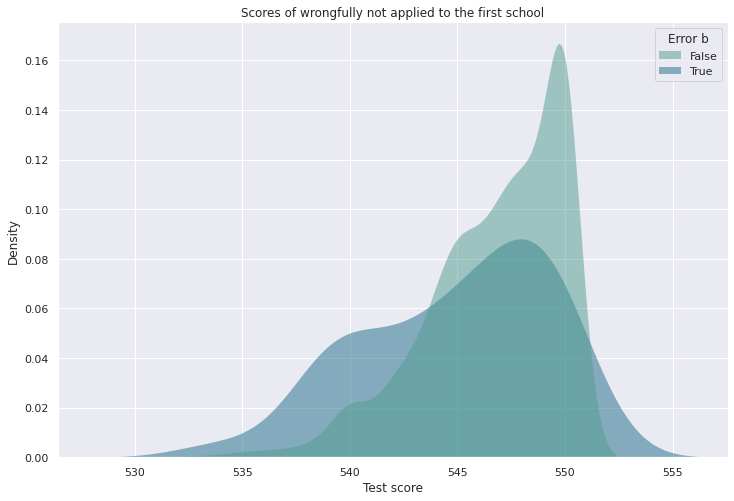

In [138]:
fig, ax = plt.subplots()

sns.kdeplot(
    data=df, x="Test score", hue="Error b", 
    palette="crest", alpha=.5, linewidth=0., fill=True,
    common_norm=False, ax=ax)

ax.set_title("Scores of wrongfully not applied to the first school")

fig.show()